<hr style="border-top-width:4px; border-top-color: #2188bf;">
<img align="right" src="images/Logo_Università_Padova.png" alt="Drawing" style="width: 300px"/>
<img align="right" src="images/Logo_Physics_of_Data.jpg" alt="Drawing" style="width: 135px"/>

# MAPD (mod.B) Final Project
# Analysis of Covid-19 papers

### Authors
* [Ardino Rocco](https://github.com/RoccoA97) (University of Padua)
* [Pagano Alice](https://github.com/AlicePagano) (University of Padua)
* [Valente Alessandro](https://github.com/mastrovalentz) (University of Padua)

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

# Index <a class="anchor" id="MAPD_B_FP.i"></a>

* 1. [**Introduction**](#MAPD_B_FP.1.)
* 2. [**Word counter distributed algorithm**](#MAPD_B_FP.2.)
    * 2.1. [**Client creation and data loading**](#MAPD_B_FP.2.1.)
    * 2.2. [**Map phase**](#MAPD_B_FP.2.2.)
    * 2.3. [**Reduce phase**](#MAPD_B_FP.2.3.)
    * 2.4. [**Analysis of the top words**](#MAPD_B_FP.2.4.)
    * 2.5. [**Timing analysis**](#MAPD_B_FP.2.5.)
* 3. [**Worst and best represented countries in the research**](#MAPD_B_FP.3.)
    * 3.1. [**Client creation and data loading**](#MAPD_B_FP.3.1.)
    * 3.2. [**Dataframe conversion algorithm**](#MAPD_B_FP.3.2.)
    * 3.3. [**Countries involvement analysis and timing**](#MAPD_B_FP.3.3.)
    * 3.4. [**Universities involvement analysis and timing**](#MAPD_B_FP.3.4.)
* 4. [**Get the embedding for the title of the papers**](#MAPD_B_FP.4.)
    * 4.1. [**Create and load embedded titles**](#MAPD_B_FP.4.1.)
    * 4.2. [**Bonus: cosine similarity**](#MAPD_B_FP.4.2.)
    
<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>

<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 1. - Introduction <a class="anchor" id="MAPD_B_FP.1."></a>
* [Index](#MAPD_B_FP.i)

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 192,000 scholarly articles, including over 84,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up. The research and related challenges are available on the dedicated page on Kaggle: https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge.
<br>
<br>

### 1.1. - Packages

In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf

from operator import itemgetter
from operator import add
from operator import iconcat

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import bokeh.palettes as palette
import seaborn as sn
import pandas as pd
import functools

import os
import json
import time

RUN_GRID_SEARCH = True

<hr style="border-top-width:4px; border-top-color: #2188bf;">

<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 2. - Word counter distributed algorithm <a class="anchor" id="MAPD_B_FP.2."></a>
* [Index](#MAPD_B_FP.i)

We implement a distributed algorithm to count the occurrences of all the words inside a list of documents using Bag data-structure of DASK. Here, we explain the algorithm step by step and in the end we wrap all the steps inside a single function in order to test the computational time required by the algorithm as a function of the number of cluster workers and the number of data partitions. 

The algorithm is divided into two parts:

* **Map phase**: for each document $D_i$, it produces the set of intermediate pairs $(w, cp(w))$, one for each word $w \in D_i$, where $cp(w)$ is the number of occurrences of $w$ in $D_i$.

* **Reduce phase**: for each word $w$, gather all the previous pairs $(w, cp(w))$ and return the final pair $(w,c(w))$ where $c(w)$ is the number of occurrences of $w$ for all the Documents. In other words, $c(w)$ is equal to $\sum_{k=1}^n {cp}_{k} (w)$.
<br>
<br>

### 2.1. - Client creation and data loading<a class="anchor" id="MAPD_B_FP.2.1."></a>

Here we create a client...

In [2]:
# Make a client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36149 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.41 GB


...and load the data.

In [3]:
# Load data and repartition
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

<br>
<br>

### 2.2. - Map phase<a class="anchor" id="MAPD_B_FP.2.2."></a>

Firstly, we merge the divided paragraphs for every single paper into a unique text. Hence, after this operation, we have 1000 paper's body texts for the following analysis.

For example, we print the body text of the first paper.

In [4]:
# Merge all the body texts in one for each file
def merge(record):
    text=''
    for rec in record:
        text+=rec['text']
    return text

texts = js.pluck("body_text").map(merge)
texts.take(1)

('Plasmodium falciparum, which causes malignant malaria such as cerebral malaria (CM) or pregnancy-associated malaria (PAM) [1, 2] , is the cause of death to 435,000 individuals annually [3] . Plasmodium falciparum erythrocyte membrane protein 1 (PfEMP1), which is encoded by the var gene family comprising approximately 60 members, is the major virulence factor involved in the antigenic variation and clinical pathogenicity of falciparum malaria [4, 5] . It is remarkable that the expression of var family members is mutually exclusive. For each parasite at a time, only one or a few var genes are expressed, while the remaining members are silenced [6, 7] . In each generation, P. falciparum is able to express different var genes, and the switches in var gene expression lead to antigenic variation of PfEMP1, which results in immune evasion and chronic infection [8] [9] [10] [11] . This process has proven to be mediated by epigenetic mechanisms, including chromatin modification, nuclear archi

The text of the documents must be sanitized (cit.) before performing analysis. So, in the following cells, we remove:

* the stop-words;

* the punctuation;

* the pure numbers;

* some other words unrelevant for our analysis.

Note that every word is considered in lower case.

In [5]:
# Function for text cleaning;
# we remove punctuation, numbers and stopwords 
# stopwords are taken from a library but also definied by us
# after this files are lists of words

tokenizer = RegexpTokenizer(r'\w+')
no_words={"i", "as", "or", "it", "et", "also", "may"}

def clean_func(text):

    def merge_text(text,stop_words):
        new_sentence =''
        for w in text:
            if w.lower() not in stop_words and w.isalpha(): 
                new_sentence += w 
                new_sentence += " "
        return new_sentence

    stop_words = set(stopwords.words('english'))
    result = word_tokenize(text)
    result = merge_text(result,stop_words.union(no_words))
    result = tokenizer.tokenize(result)
    return result

text_clean = texts.map(clean_func)
text_clean.take(1)[0][:10]

['Plasmodium',
 'falciparum',
 'causes',
 'malignant',
 'malaria',
 'cerebral',
 'malaria',
 'CM',
 'malaria',
 'PAM']

After the cleaning operation, we count each unique word and its frequency. For the following part, we organize the result into the path:
 
    {'word': 'word_name', 'counts': count_val}

In [6]:
# We transform each list in a list of dictionaries 
# where the unique words and their frequency is stored

def count_words(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    wList = [{"word":x , "counts": y} for x,y in counts.items()]
    return wList

words = text_clean.map(count_words)
words.take(1)

([{'word': 'Plasmodium', 'counts': 5},
  {'word': 'falciparum', 'counts': 27},
  {'word': 'causes', 'counts': 2},
  {'word': 'malignant', 'counts': 1},
  {'word': 'malaria', 'counts': 6},
  {'word': 'cerebral', 'counts': 1},
  {'word': 'CM', 'counts': 1},
  {'word': 'PAM', 'counts': 1},
  {'word': 'cause', 'counts': 1},
  {'word': 'death', 'counts': 1},
  {'word': 'individuals', 'counts': 1},
  {'word': 'annually', 'counts': 1},
  {'word': 'erythrocyte', 'counts': 1},
  {'word': 'membrane', 'counts': 1},
  {'word': 'protein', 'counts': 19},
  {'word': 'encoded', 'counts': 1},
  {'word': 'var', 'counts': 58},
  {'word': 'gene', 'counts': 36},
  {'word': 'family', 'counts': 6},
  {'word': 'comprising', 'counts': 2},
  {'word': 'approximately', 'counts': 2},
  {'word': 'members', 'counts': 4},
  {'word': 'major', 'counts': 5},
  {'word': 'virulence', 'counts': 3},
  {'word': 'factor', 'counts': 2},
  {'word': 'involved', 'counts': 9},
  {'word': 'antigenic', 'counts': 3},
  {'word': 'vari

<br>
<br>

### 2.3. - Reduce phase<a class="anchor" id="MAPD_B_FP.2.3."></a>

Trough the DASK function `foldby`, we sum the counts for every unique word over all the papers... 

In [7]:
# At last we sum over all file using the foldby method
# we pass the bag to the foldby after flattening it 
# the methos accesse the dictiornarios grouping them with the value associated to the key word
# and the sum the counts of each word

def incr_amount(tot, x):
    return tot+x['counts']

total_counts = words.flatten().foldby('word', binop=incr_amount, 
                                      initial=0, combine=add, 
                                      combine_initial=0).compute()

total_counts

[('Plasmodium', 52),
 ('falciparum', 68),
 ('causes', 726),
 ('malignant', 170),
 ('malaria', 199),
 ('cerebral', 397),
 ('CM', 11),
 ('PAM', 13),
 ('cause', 1355),
 ('death', 1076),
 ('individuals', 1340),
 ('annually', 66),
 ('erythrocyte', 33),
 ('membrane', 1145),
 ('protein', 5029),
 ('encoded', 277),
 ('var', 66),
 ('gene', 2868),
 ('family', 1042),
 ('comprising', 111),
 ('approximately', 703),
 ('members', 654),
 ('major', 1573),
 ('virulence', 256),
 ('factor', 1314),
 ('involved', 1392),
 ('antigenic', 288),
 ('variation', 426),
 ('clinical', 4287),
 ('pathogenicity', 100),
 ('remarkable', 109),
 ('expression', 3525),
 ('mutually', 39),
 ('exclusive', 62),
 ('parasite', 259),
 ('time', 4481),
 ('one', 4704),
 ('genes', 2162),
 ('expressed', 1200),
 ('remaining', 375),
 ('silenced', 11),
 ('generation', 412),
 ('able', 1007),
 ('express', 345),
 ('different', 4561),
 ('switches', 26),
 ('lead', 850),
 ('results', 4377),
 ('immune', 2301),
 ('evasion', 48),
 ('chronic', 1072),


...and we sort the result depending on the counts.

In [8]:
# At last we order the obtained list

total_counts_ordered = sorted(total_counts, key=itemgetter(1), reverse=True)
total_counts_ordered

[('patients', 11585),
 ('cells', 10922),
 ('virus', 8325),
 ('study', 7364),
 ('infection', 7300),
 ('used', 7040),
 ('using', 6974),
 ('viral', 5890),
 ('data', 5860),
 ('disease', 5762),
 ('al', 5615),
 ('cell', 5241),
 ('two', 5065),
 ('protein', 5029),
 ('Fig', 4724),
 ('one', 4704),
 ('different', 4561),
 ('time', 4481),
 ('studies', 4420),
 ('results', 4377),
 ('clinical', 4287),
 ('could', 4064),
 ('number', 4046),
 ('human', 4014),
 ('cases', 4014),
 ('However', 3754),
 ('analysis', 3746),
 ('use', 3739),
 ('treatment', 3724),
 ('found', 3682),
 ('group', 3676),
 ('high', 3661),
 ('RNA', 3638),
 ('viruses', 3638),
 ('expression', 3525),
 ('respiratory', 3498),
 ('model', 3488),
 ('Figure', 3477),
 ('including', 3425),
 ('shown', 3389),
 ('associated', 3359),
 ('reported', 3332),
 ('control', 3319),
 ('first', 3273),
 ('system', 3183),
 ('response', 3166),
 ('well', 3118),
 ('proteins', 3051),
 ('infections', 2983),
 ('compared', 2955),
 ('Table', 2930),
 ('important', 2901),
 (

<br>
<br>

### 2.4. - Analysis of the top words<a class="anchor" id="MAPD_B_FP.2.4."></a>

In this subsection, we analyze the top words and how they are related to the viruses and the research. In particular, we define a function which, given the unique words and the relative counts, it returns the $n$ most frequent words in all the papers in a pretty barplot.


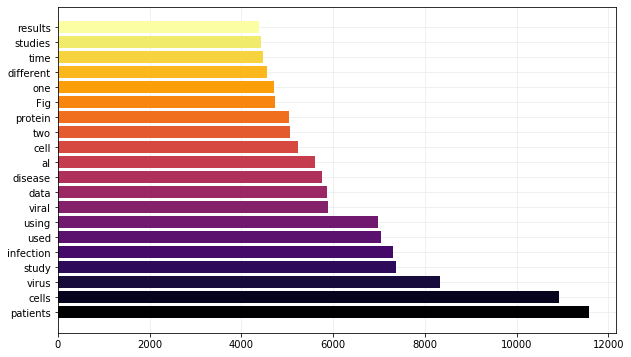

In [9]:
def plot_topwords(word_sorted, n):
    height = [word_sorted[i][1] for i in range(0,len(word_sorted))]
    bars = [word_sorted[i][0] for i in range(0,len(word_sorted))]
    y_pos = np.arange(len(bars))
    
    fig, ax = plt.subplots(figsize=(10,int(n*0.3)))
    index = n
    # Create bars
    ax.barh(y_pos[:index], height[:index],color=palette.inferno(index))
    plt.yticks(y_pos[:index], bars[:index])
    ax.grid(True, which="both", ls="-",color='0.93')
    ax.set_axisbelow(True)

plot_topwords(total_counts_ordered, 20)

In [10]:
client.close()

<br>
<br>

### 2.5. - Timing analysis<a class="anchor" id="MAPD_B_FP.2.5."></a>

We are interested in the computational time required by the whole procedure explained before, depending on the number of workers in the cluster and on the number of partitions in which data is divided.

For this purpose, we wrap every needed operation inside a single function.

In [11]:
def get_time(workers=4, partitions=10):
    # Make cluster
    myCluster = LocalCluster(n_workers=workers)
    # Make client
    client = Client(myCluster) 
    
    # Register start time
    start = time.time() 
    
    # Load data and repartition
    filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
    lines = db.read_text(filename)

    # Algorithm
    word_count = (lines.map(json.loads).repartition(partitions).pluck('body_text')
                       .map(merge).map(clean_func)
                       .map(count_words).flatten()
                       .foldby('word', binop=incr_amount, 
                               initial=0, combine=add, 
                               combine_initial=0).compute())
    word_sorted = sorted(word_count, key=itemgetter(1), reverse=True)
    
    # Register end time
    end = time.time()
    
    # Close client
    client.close()
    # Close cluster
    myCluster.close() 
    
    return end-start

Then, we apply a grid search for this timing analysis and we store the results.

In [12]:
if(RUN_GRID_SEARCH):
    # Number of workers
    works = [1,2,4,8,12]
    # Partitions factor
    parts = [1,2,3,4] 

    times = np.zeros((len(works),len(parts))) 

    for w in range(len(works)):
        for p in range(len(parts)):
            times[w][p] = get_time(works[w],parts[p]*works[w])
            print("nw: ", works[w], " partitions: ", parts[p]*works[w], " time [s]: ", times[w][p])

nw:  1  partitions:  1  time [s]:  36.03933382034302
nw:  1  partitions:  2  time [s]:  34.62495422363281
nw:  1  partitions:  3  time [s]:  34.61866092681885
nw:  1  partitions:  4  time [s]:  35.10944604873657
nw:  2  partitions:  2  time [s]:  22.57848024368286
nw:  2  partitions:  4  time [s]:  27.448301792144775
nw:  2  partitions:  6  time [s]:  20.10725450515747
nw:  2  partitions:  8  time [s]:  21.640633583068848
nw:  4  partitions:  4  time [s]:  15.599312782287598
nw:  4  partitions:  8  time [s]:  18.34414768218994
nw:  4  partitions:  12  time [s]:  15.284252166748047
nw:  4  partitions:  16  time [s]:  16.100508213043213
nw:  8  partitions:  8  time [s]:  12.738649606704712
nw:  8  partitions:  16  time [s]:  12.263591051101685
nw:  8  partitions:  24  time [s]:  13.21226716041565
nw:  8  partitions:  32  time [s]:  12.143641948699951
nw:  12  partitions:  12  time [s]:  11.556567907333374
nw:  12  partitions:  24  time [s]:  13.360182762145996
nw:  12  partitions:  36  t

For a better visualization, we plot the results in a matrix format with a seaborn heatmap.

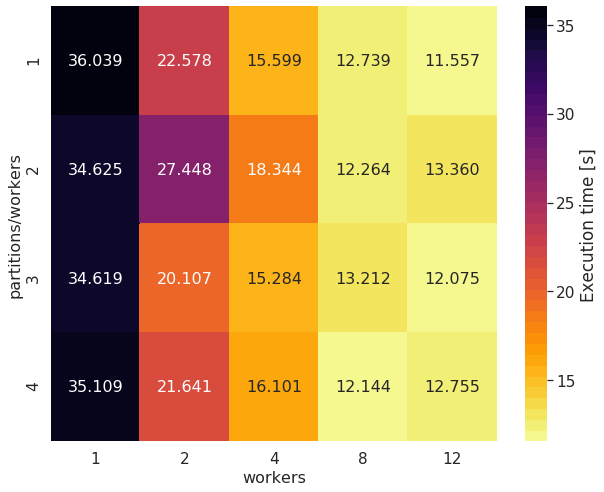

In [13]:
if(RUN_GRID_SEARCH):
    # Create a dataframe of timing results
    df_cm = pd.DataFrame(times.T, parts, works)
    # Plot the heatmap
    plt.figure(figsize=(10,8))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
    plt.xlabel('workers',fontsize=16)
    plt.ylabel('partitions/workers',fontsize=16)
    plt.show()
    plt.style.use('default')

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 3. - Worst and best represented countries in the research <a class="anchor" id="MAPD_B_FP.3."></a>
* [Index](#MAPD_B_FP.i)

In this part, we take the documents and convert them in a dataframe data structure in order to figure out the countries that are most and less active in the research. To do this, we use the country of the authors.
Moreover, we do the same for the universities (affiliations).

Even in this case, we do multiple runs by changing the number of partitions and workers and then we describe the behaviour of the timings.
<br>
<br>

### 3.1. - Client creation and data loading<a class="anchor" id="MAPD_B_FP.3.1."></a>

Here, we create a client...

In [14]:
# Create a cluster and a client
cluster = LocalCluster(n_workers=2)
client = Client(cluster)

...and load the data.

In [15]:
# Load the data
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')
lines = db.read_text(filename)
js = lines.map(json.loads).repartition(10)

<br>
<br>

### 3.2. - Dataframe conversion algorithm<a class="anchor" id="MAPD_B_FP.3.2."></a>

We create a dataframe structure through several operations that we list in the following cells.

We pluck the data regarding the authors.

In [16]:
# Pluck 'metadata' and then 'authors'
authors = js.pluck('metadata').pluck('authors')

We preprocess this data for a better handling for the following analysis. We do it through a user-defined function.

In [17]:
# Flatten information of the authors
def flatten(record):
    uni=loc=lab=''
    if 'institution' in record['affiliation'].keys():
        uni=record['affiliation']['institution']
    else: uni="Unknown"
    
    if 'laboratory' in record['affiliation'].keys():
        lab=record['affiliation']['laboratory']
    else: lab="Unknown"
    
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            loc=record['affiliation']['location']['country']
        else: loc="Unknown"
    else: loc="Unknown"
    
    if uni=='': uni="Unknown"
    if lab=='': lab="Unknown"
    if loc=='': loc="Unknown"
    
    return {
        'name':       record['first'],
        'surname':    record['last'], 
        'University': uni,
        'Laboratory': lab,
        'Country':    loc,
    }

authors.flatten().map(flatten).take(1)

({'name': 'Wei-Feng',
  'surname': 'Wang',
  'University': 'Second Military Medical University',
  'Laboratory': 'Unknown',
  'Country': 'China'},)

Now, we can easily create the dataframe.

In [18]:
# Convert dataset to dataframe structure
auth_df = authors.flatten().map(flatten).to_dataframe()
auth_df.head()

,name,surname,University,Laboratory,Country
0,Wei-Feng,Wang,Second Military Medical University,Unknown,China
1,Yi-Long,Zhang,Second Military Medical University,Unknown,China
2,Chih-Cheng,Lai,Chi Mei Medical Center,Unknown,Taiwan
3,Chen-Chen,Chu,National Taiwan University Hospital,Unknown,Taiwan
4,Aristine,Cheng,New Taipei City,Unknown,Taiwan


<br>
<br>

### 3.3. - Countries involvement analysis and timing<a class="anchor" id="MAPD_B_FP.3.3."></a>

Now, we apply a similar analysis of the [previous section](#MAPD_B_FP.2.) but for the names of the countries figuring in the metadata of the authors.

In [19]:
def plot_top(data, n):
    data = data.nlargest(n+1).compute()
    data = data[data.axes[0]!='Unknown']
    height = [data[i] for i in range(0,n)]
    bars = [data.axes[0][i] for i in range(0,n)]
    y_pos = np.arange(len(bars))
    
    fig, ax = plt.subplots(figsize=(10,int(n*0.3)))
    index = n
    # Create bars
    ax.barh(y_pos[:index], height[:index],color=palette.inferno(index))
    plt.yticks(y_pos[:index], bars[:index])
    ax.grid(True, which="both", ls="-",color='0.93')
    ax.set_axisbelow(True)

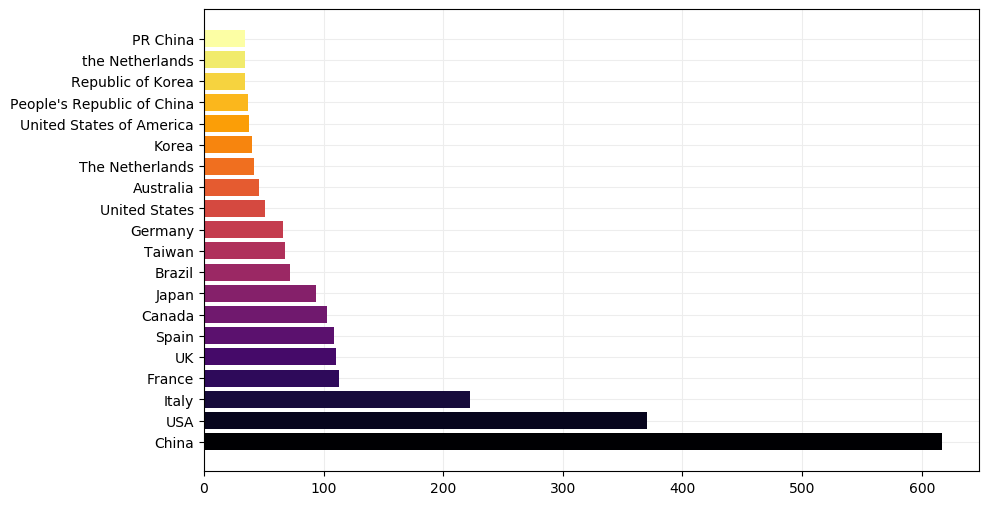

In [20]:
countries = auth_df.Country.value_counts()

plot_top(countries, 20)

Then, we apply a grid search for the timing analysis and we store the results.

In [21]:
def get_time_countries(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    client = Client(myCluster) #make client
    start = time.time() #start taking time
    auth_df = (lines.map(json.loads).repartition(partitions)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    countries = auth_df.Country.value_counts().nlargest(10).compute()
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start

In [22]:
if(RUN_GRID_SEARCH):
    # Number of workers
    works = [1,2,4,8,12]
    # Partitions factor
    parts = [1,2,3,4] 

    times_countries = np.zeros((len(works),len(parts))) 

    for w in range(len(works)):
        for p in range(len(parts)):
            times_countries[w][p] = get_time_countries(works[w],parts[p]*works[w])
            print("nw: ", works[w], " partitions: ", parts[p]*works[w], " time [s]: ", times_countries[w][p])

/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40753 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  1  time [s]:  10.646317958831787


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41321 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  2  time [s]:  10.23915982246399


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38811 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  3  time [s]:  10.3800368309021


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46173 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  4  time [s]:  10.240068674087524


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44893 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  2  time [s]:  7.291026592254639


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38863 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  4  time [s]:  7.2104527950286865


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33815 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  6  time [s]:  7.606473207473755


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46367 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  8  time [s]:  7.77512526512146


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37867 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  4  time [s]:  5.509926080703735


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46655 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  8  time [s]:  5.487782001495361


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42117 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  12  time [s]:  5.6843719482421875


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38641 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  16  time [s]:  5.358031749725342


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39455 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  8  time [s]:  4.664334058761597


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35685 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  16  time [s]:  4.794153928756714


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43187 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  24  time [s]:  4.4694507122039795


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37789 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  32  time [s]:  4.75239634513855


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36983 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  12  time [s]:  4.715607404708862


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34169 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  24  time [s]:  4.413816452026367


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46601 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  36  time [s]:  4.804329872131348


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41313 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  48  time [s]:  4.45943284034729


For a better visualization, we plot the results in a matrix format with a seaborn heatmap.

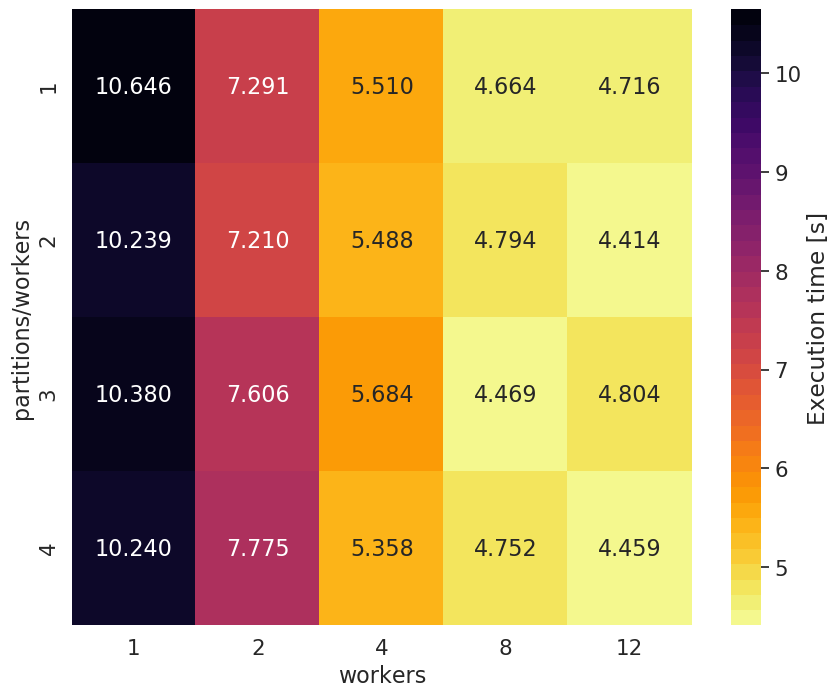

In [23]:
if(RUN_GRID_SEARCH):
    # Create a dataframe of timing results
    df_cm = pd.DataFrame(times_countries.T, parts, works)
    # Plot the heatmap
    plt.figure(figsize=(10,8))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
    plt.xlabel('workers',fontsize=16)
    plt.ylabel('partitions/workers',fontsize=16)
    plt.show()
    plt.style.use('default')

<br>
<br>

### 3.4. - Universities involvement analysis and timing<a class="anchor" id="MAPD_B_FP.3.4."></a>

Now, we apply a similar analysis of the [previous section](#MAPD_B_FP.2.) but for the names of the universities figuring in the metadata of the authors.

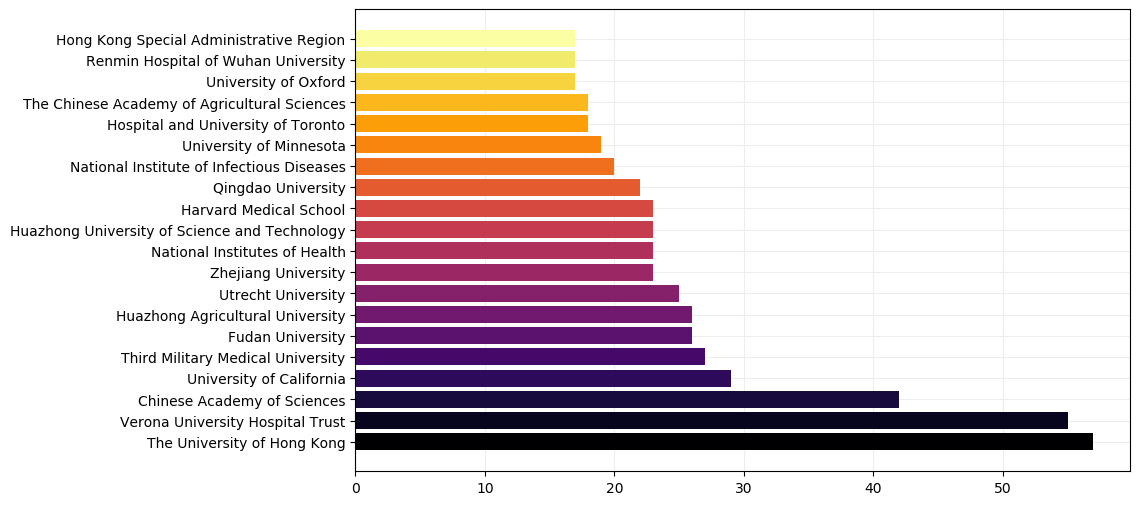

In [24]:
univs = auth_df.University.value_counts()

plot_top(univs, 20)

Then, we apply a grid search for the timing analysis and we store the results.

In [25]:
def get_time_univs(workers=4, partitions=10):
    myCluster = LocalCluster(n_workers=workers)
    cliemnt = Client(myCluster) #make client
    start = time.time() #start taking time
    auth_df = (lines.map(json.loads).repartition(partitions)
                    .pluck('metadata').pluck('authors')
                    .flatten().map(flatten)
                    .to_dataframe())
    univs = auth_df.University.value_counts().nlargest(10).compute()
    end = time.time()
    client.close() #close client
    myCluster.close() #close cluster
    return end-start

In [26]:
if(RUN_GRID_SEARCH):
    # Number of workers
    works = [1,2,4,8,12]
    # Partitions factor
    parts = [1,2,3,4] 

    times_univ = np.zeros((len(works),len(parts))) 

    for w in range(len(works)):
        for p in range(len(parts)):
            times_univ[w][p] = get_time_countries(works[w],parts[p]*works[w])
            print("nw: ", works[w], " partitions: ", parts[p]*works[w], " time [s]: ", times_univ[w][p])

/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34119 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  1  time [s]:  10.694599390029907


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46217 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  2  time [s]:  10.611947536468506


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44215 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  3  time [s]:  10.535597324371338


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44209 instead
  http_address["port"], self.http_server.port


nw:  1  partitions:  4  time [s]:  11.124062538146973


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46861 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  2  time [s]:  7.514486789703369


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36135 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  4  time [s]:  7.992972135543823


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42153 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  6  time [s]:  7.742794990539551


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40141 instead
  http_address["port"], self.http_server.port


nw:  2  partitions:  8  time [s]:  7.478033065795898


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41399 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  4  time [s]:  5.5734124183654785


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38453 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  8  time [s]:  5.621343374252319


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41299 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  12  time [s]:  5.465777158737183


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39577 instead
  http_address["port"], self.http_server.port


nw:  4  partitions:  16  time [s]:  5.8790669441223145


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38447 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  8  time [s]:  4.620568513870239


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34981 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  16  time [s]:  5.098645448684692


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34263 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  24  time [s]:  4.6110429763793945


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44265 instead
  http_address["port"], self.http_server.port


nw:  8  partitions:  32  time [s]:  5.026400566101074


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39205 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  12  time [s]:  4.671259641647339


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36537 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  24  time [s]:  4.866207599639893


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38727 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  36  time [s]:  4.457395553588867


/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41971 instead
  http_address["port"], self.http_server.port


nw:  12  partitions:  48  time [s]:  4.503453493118286


For a better visualization, we plot the results in a matrix format with a seaborn heatmap.

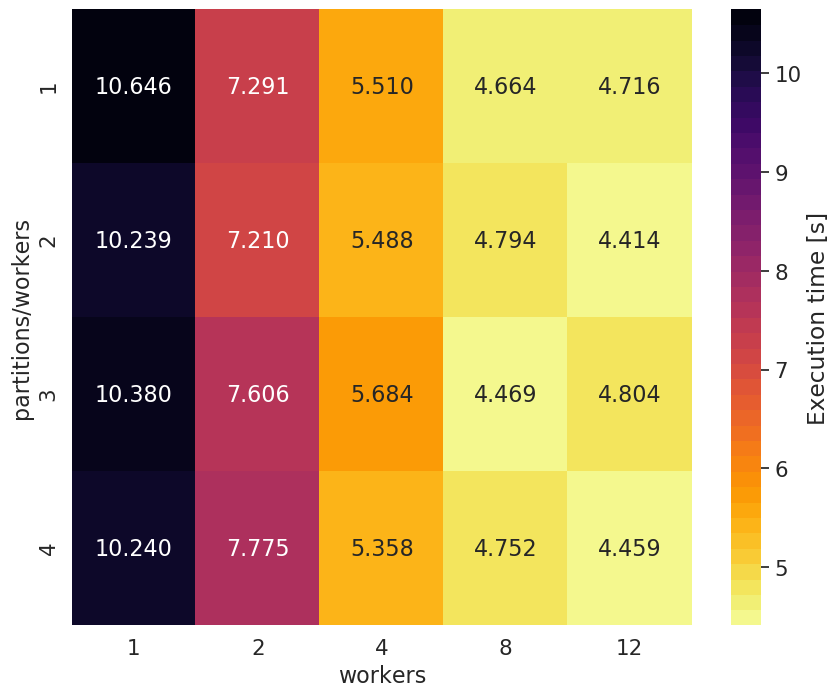

In [27]:
if(RUN_GRID_SEARCH):
    # Create a dataframe of timing results
    df_cm = pd.DataFrame(times_countries.T, parts, works)
    # Plot the heatmap
    plt.figure(figsize=(10,8))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sn.color_palette("inferno_r",40))
    plt.xlabel('workers',fontsize=16)
    plt.ylabel('partitions/workers',fontsize=16)
    plt.show()
    plt.style.use('default')

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 4. - Get the embedding for the title of the papers <a class="anchor" id="MAPD_B_FP.4."></a>
* [Index](#MAPD_B_FP.i)

In NLP a common technique to perform analysis over a set of texts is to transform the text to a set of vectors each one representing a word inside a document. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of $n \times m$ where $n$ is the number of words in the document and $m$ is the size of the vector that represents the word $n$.

<br>
<br>

### 4.1. - Create and load embedded titles<a class="anchor" id="MAPD_B_FP.4.1."></a>

It is interesting to transform the title of a paper into its embedding version by using a pre-trained model available on FastText page.

However, the dictionary provided is too heavy to be used in jupyter, as well as the other model present at FastText web site (https://fasttext.cc/docs/en/crawl-vectors.html).

Therefore, we download a pretrained module instead of a dictionary, in order to be able to load it with the **Gensim** package which is more efficient in terms of resources. 
Then, in order to embed the titles of the papers we use a Python script, where:

* a dask client and cluster is created;
* the papers are retrived from the json files using a dask.bag;
* the bag is flattened to a list contataining only the title and the ID of the paper;
* the FastText model is loaded and it embeds the titles;
* client and cluster are closed.

In particular:

* the model returns an array of 300 float numbers for each word so that the output is a dictionary with a value represented by a list of arrays;
* in order to store the files in a json format, the arrays have to be transformed to string lists.

Here, we can see the script:

In [28]:
# If installed, vimcat for a better visualization
# ! vimcat FastTextModel.py
! cat FastTextModel.py

# Import packages
from dask.distributed import Client, LocalCluster
from dask import delayed

import dask.bag as db
import dask.dataframe as ddf
import os
import json
from operator import itemgetter
from operator import add

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize

from collections import Counter

import time

import numpy as np

import io
import fasttext


def embed(text, model):
    text_split = text.split()
    text_embedded = []
    #just to be safe that the .bin model does predict everything
    for t in text_split:
        try:
            text_embedded.append(model[t])
        except:
            pass
    text_string = [["%.8f" % n for n in w] for w in text_embedded]

    return text_string


def embed_dict(dict, model):
    return{
        "paper_id": dict["paper_id"],
        "title": embed(dict['title'], model)
    }


def flatten(reco):
    return {
        "paper_id": reco[0],
        "title": reco[1]['title

After this step, we can load the embedded files in Jupyter using the DASK Bag inteface. 

Here, we create a client...

In [29]:
# Create a client
cluster = LocalCluster(n_workers=4)
client  = Client(cluster)
client

/home/rocco/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38219 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:35425 Dashboard: http://127.0.0.1:38219/status,Cluster Workers: 4 Cores: 12 Memory: 16.41 GB


...and load the embedded data.

In [30]:
# Load embedded papers
filename = os.path.join('data', 'embedded_papers', '*.json')
js = db.read_text(filename).map(json.loads)

<br>
<br>

### 4.2. - Bonus: cosine similarity<a class="anchor" id="MAPD_B_FP.4.2."></a>

We use the previously generated vectors to compute the cosine similarity between each paper and to figure out a couple of papers with the highest cosine similarity score.

The string format which we use to save the embedded files is not suitable for mathematical computations, so we reconvert the string lists to numpy arrays.

In [31]:
def back_to_float(l):
    return np.array([[float(n) for n in arr]for arr in l])

def db_to_float(reco):
    return {
        "paper_id": reco['paper_id'],
        "title": back_to_float(reco['title'])
    }

titles = db.from_sequence(js.map(db_to_float).compute())
titles.take(1)

({'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title': array([[-4.4659150e-02,  1.5186340e-02, -3.3508370e-02, ...,
           1.7950660e-02, -9.7958100e-03, -2.5739150e-02],
         [ 8.7643050e-02, -4.9590126e-01, -4.9854990e-02, ...,
           5.3485096e-01, -5.5810360e-02, -1.6598430e-02],
         [-2.8673020e-02, -2.5425730e-02, -5.1420850e-02, ...,
           5.7633900e-02, -4.3897000e-04,  2.2708240e-02],
         ...,
         [-1.4047040e-02, -2.5217462e-01,  7.1501930e-02, ...,
           1.3704422e-01,  4.5107400e-03,  3.2923460e-02],
         [ 3.6612860e-02, -5.9771530e-02, -1.7483340e-02, ...,
           1.0073350e-01,  2.0367010e-02,  2.8794700e-03],
         [ 5.6244680e-02, -1.6394550e-02,  5.0384400e-03, ...,
           3.6305250e-02, -5.7916600e-03, -9.9020800e-03]])},)

The cosine similarity is computed by calculating the cosine of the angle from the title vectors up to the lowest number of words of the two (e.g. the first 2 titles have 15 and 29 words respectively so we compute the cosine of the first 15 words) and then mean over it.

In [32]:
# Function to compute the cosine similarity
def cos_sim(x,y):
    l   = min(x.shape[0], y.shape[0])
    nx  = np.sqrt(np.sum(np.multiply(x,x)))
    ny  = np.sqrt(np.sum(np.multiply(y,y)))
    res = np.sum(np.multiply(x[:l],y[:l]))/(nx*ny)
    if res==np.Inf:
        return 0.
    else:
        return res

# Function for computing the cosine similarity for dask.bag
def make_sim_bag(reco):
    try:
        c= cos_sim(reco[0]['title'], reco[1]['title'])
    except:
        c=0
    return {
        "Paper1:": reco[0]['paper_id'],
        "Paper2:": reco[1]['paper_id'],
        "Similarity": c
    }

# Function for computing the cosine similarity for arrays
def make_sim_reco(reco1, reco2):
    try:
        c= cos_sim(reco1['title'], reco2['title'])
    except:
        c=0
    return {
        "Paper1:": reco1['paper_id'],
        "Paper2:": reco2['paper_id'],
        "Similarity": c
    }

In order to map this word over a dask.bag, we need to create a grid over a list and map it. For instance, let us consider the first 10 papers.

In [33]:
# Apply the functions to compute the cosine similarity for 10x10 batch
title_list = js.map(db_to_float).compute()
batch      = (db.from_sequence([(title_list[i], title_list[j]) for i in range(10) for j in range(10) ])
                .repartition(8).map(make_sim_bag).compute())

# Take the first element of the batch
batch[0]

{'Paper1:': '000a0fc8bbef80410199e690191dc3076a290117',
 'Paper2:': '000a0fc8bbef80410199e690191dc3076a290117',
 'Similarity': 1.0}

The problem of this approach is that for a small grid it is really fast, but this procedure scales with $N^2$ over the memory consumption. For this reason, it is not possible to apply the above code to the full dataset and it is necessary to run it in batches. Moreover, it is necessary to clean the memory after results of a batch are obtained. Let us calculate the computational time required by this approach.

In [34]:
%%time 

# Number of papers to consider
l=10 
# Number of batches into which we divide data
nb=10

sims=[]
for i in range(int(l/nb)+1):
    for j in range(i, int(l/nb)+1):
        batch= db.from_sequence([(title_list[k], title_list[m]) for k in range(i*nb, min((i+1)*nb,l)) for m in range(j*nb, min((j+1)*nb+i,l)) ]).repartition(8)
        sims.append(batch.map(make_sim_bag).compute())
        del batch
        
sims_par = functools.reduce(iconcat, sims, [])

CPU times: user 401 ms, sys: 46.2 ms, total: 447 ms
Wall time: 395 ms


As we can see from the cells below a serial approach is way faster and is also less lighter is terms of resources needed.

In [35]:
%%time

# Number of papers to consider
l=10

sims_ser=[]
for i in range(l):
    for j in range(i,l):
        sim = make_sim_reco(title_list[i], title_list[j])
        sims_ser.append(sim)

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 9.89 ms


Now, we (serially) compute all the similarities between the papers. For this analysis, we store the informations in two differen ways: 

* by creating a numpy matrix, where each element is associated to the $i$ and $j$ papers;
* by creating a dask dataframe, where each entry has the ID of the papers and their similarity.
 

Hence, using numpy arrays we have:

In [36]:
# Number of papers to consider
l=1000 # or len(title_list)

#sim_matrix = np.eye(l,l)
# using identity will make other papers invisible in the plot so we use zeros
# even thou we know that inthe diagonal all the elements have 1 as similarity
sim_matrix = np.zeros((l,l))

sims_ser=[]
for i in range(l):
    if (i%(l/10)==0): print("Status: ", i)
    for j in range(i+1,l):
        sim = make_sim_reco(title_list[i], title_list[j])
        sims_ser.append(sim)
        sim_matrix[i,j]=sim['Similarity']
        sim_matrix[j,i]=sim['Similarity'] #matrix is symmetric

        
sims_ddf = ddf.from_pandas(pd.DataFrame(sims_ser), npartitions=10)

print("Non zero similarities:", sims_ddf[sims_ddf['Similarity']>0].Similarity.count().compute())
sims_ddf.head()

Status:  0


/home/rocco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Status:  100
Status:  200
Status:  300
Status:  400
Status:  500
Status:  600
Status:  700
Status:  800
Status:  900
Non zero similarities: 404036


,Paper1:,Paper2:,Similarity
0,000a0fc8bbef80410199e690191dc3076a290117,000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a,0.035207
1,000a0fc8bbef80410199e690191dc3076a290117,00a407540a8bdd6d7425bd8a561eb21d69682511,0.088574
2,000a0fc8bbef80410199e690191dc3076a290117,0a256d2a62ed04438adbb9f406fd7522b80f8c5f,0.057497
3,000a0fc8bbef80410199e690191dc3076a290117,0a27031e9ae48b60e6d1b337c0a4270223dd1c30,0.075667
4,000a0fc8bbef80410199e690191dc3076a290117,0a273f78945e7abadfb6f7b81c540cca8003616b,0.108544


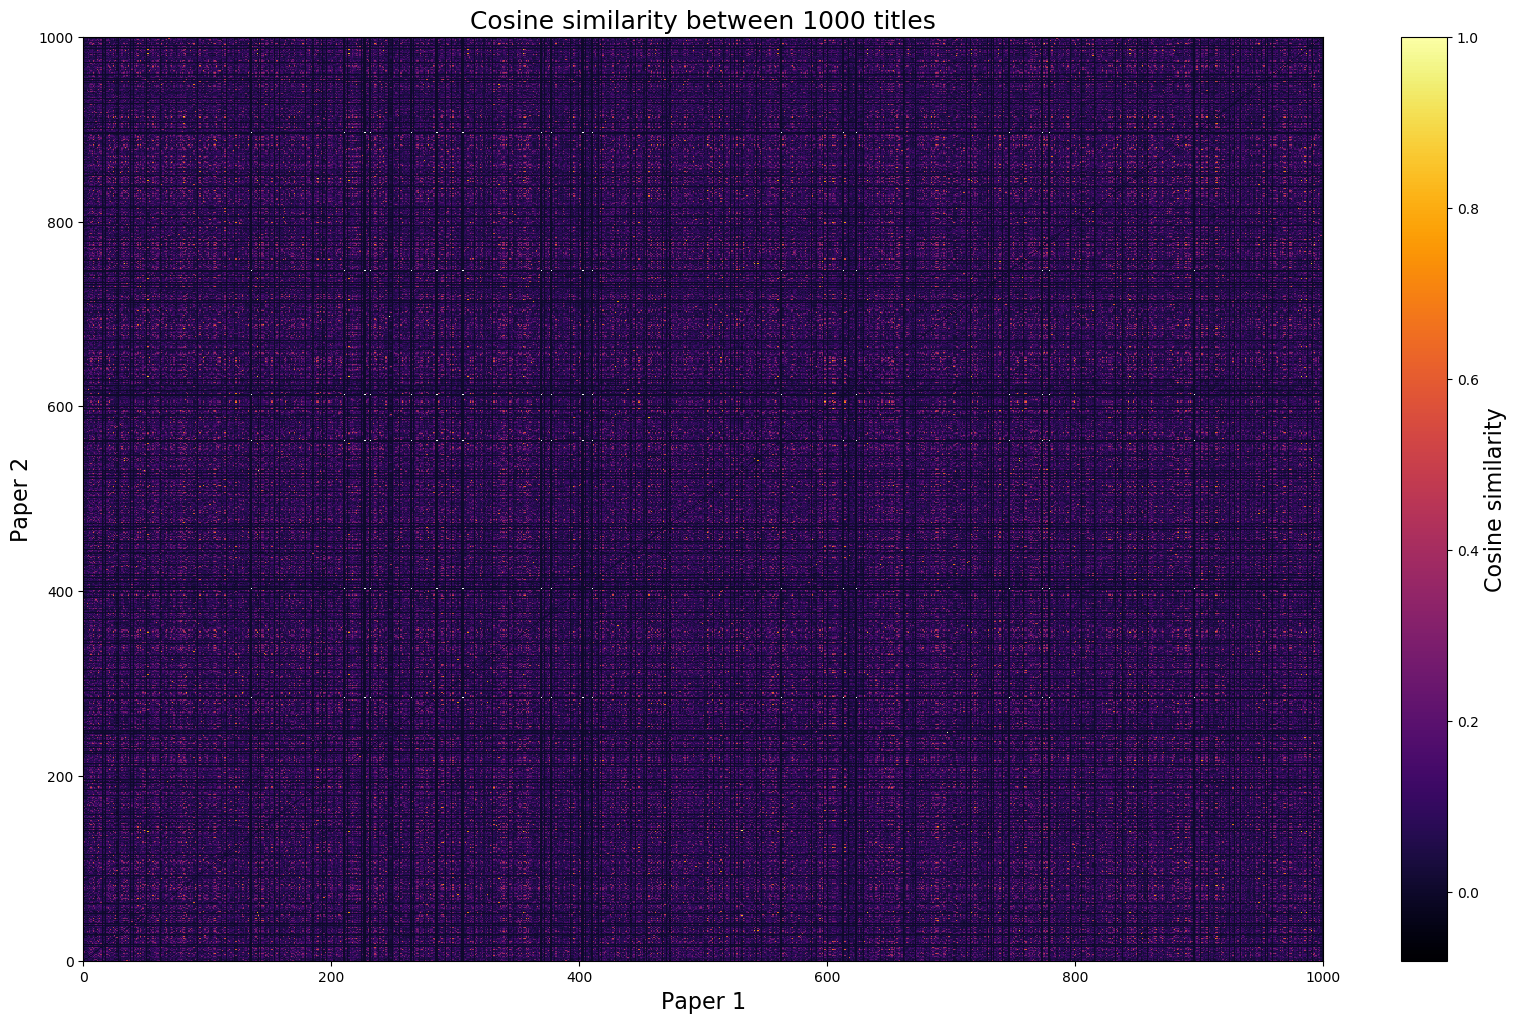

In [37]:
fig, ax = plt.subplots(figsize=(20,12))
pcm  = ax.pcolormesh(sim_matrix, cmap='inferno')
cmap = fig.colorbar(pcm, ax=ax)
cmap.set_label('Cosine similarity',fontsize=16)
ax.set_title('Cosine similarity between {0} titles'.format(l),fontsize=18)
ax.set_xlabel('Paper 1',fontsize=16)
ax.set_ylabel('Paper 2',fontsize=16)
plt.show()

As we can see there are not too many combinations with high similarity values.

In order to see the most similar paper titles, we analyze the dataframe. For instance, we show the first five papers with highest cosine similarity. 

In [38]:
sims_ddf = sims_ddf[sims_ddf['Similarity']>0].compute()

In [39]:
sims_ddf_largest = sims_ddf.nlargest(10, ['Similarity'])
sims_ddf_largest

,Paper1:,Paper2:,Similarity
216821,0ada158e5af242ffafe0c15d5af9d3c5f141e709,0c41ec48ace1522ef6efb0deca6a6f2864213bb5,1.000000
131378,0a8e6fec2ec51e268a0e5c4216484e20ad1a52b1,0bbfbaaf1a302da40204fe62e192ac839218b0e9,0.936078
171702,0ab46b1df9e05687a789426f9c2d76a56087b072,0ca486c3ab1a5050411a08f1cd9c1fa4dd447128,0.882314
432321,0c0d3ae86e9c83dfc795a58ae2ecad154feff32f,0d2ef48a0b17f56cf8494fe49f0b6d9643c03a7b,0.865513
474517,0c7db307d26ea03754a93b1892fff1831553e5b6,0d3fa6e484df23c41bdbb2b55fd13e733225ea49,0.856838
130971,0a8d9887e378df263878873a4b7be141aa224b42,0d2ef48a0b17f56cf8494fe49f0b6d9643c03a7b,0.849660
418905,0bf1d9a2e53cd72c53a76930f5b37d4957678417,0bf614ec42d27fa30f001e67ee0c2ae40fe8ed3b,0.848411
469844,0c70587aba7fdbbf833d9281eb4efe044044a2c8,0d3d6464fface2f849bdc3689bd0fc2b46c4366f,0.844953
394602,0bc493404a0f56928b1f5762c40cd1952e563e7d,0c70587aba7fdbbf833d9281eb4efe044044a2c8,0.836885
78511,0a636ed5d9919a4b03a20e2d9dd3dda0a2039ec0,0cd911d564b693ebedf57fa37c28b8ea5705c174,0.836154


By using their ID, we can retrieve their titles.

In [40]:
# Load the data
filename = os.path.join('data', 'papers_in_json_singleline', '*.json')

def flatten(reco):
    return {
        "paper_id": reco[0],
        "title": reco[1]['title']
    }

titles_ddf = ddf.from_pandas(pd.DataFrame(db.read_text(filename)
                                            .map(json.loads)
                                            .repartition(10)
                                            .pluck(["paper_id", "metadata"])
                                            .map(flatten).compute()), npartitions=50)

And after this we compare the two DASK dataframes in order to find the corresponding titles.

In [41]:
def get_titles(ddf_elem):
    d = titles_ddf[titles_ddf.paper_id.isin([ddf_elem[0], ddf_elem[1]])].title.compute()
    return {
        "Title1" : d.iloc[0],
        "Title2" : d.iloc[1],
    }
get_titles(sims_ddf_largest.iloc[1])

{'Title1': 'To appear in: Resuscitation',
 'Title2': 'To appear in: Public Health'}

We also print the first ten results with a higher cosine similiarity value.

In [42]:
n = 10
print("1 *********************************************************")
for i in range(n):
    print("  Title 1:    ", get_titles(sims_ddf_largest.iloc[i])['Title1'])
    print("  Title 2:    ", get_titles(sims_ddf_largest.iloc[i])['Title2'])
    print("  Similarity: ", sims_ddf_largest.iloc[i][2])
    if i!=(n-1): print("{0} *********************************************************".format(i+2))

1 *********************************************************
  Title 1:     Original Article
  Title 2:     Original Article
  Similarity:  0.9999999999999998
2 *********************************************************
  Title 1:     To appear in: Resuscitation
  Title 2:     To appear in: Public Health
  Similarity:  0.9360775870553655
3 *********************************************************
  Title 1:     The daily impact of COVID-19 in gastroenterology
  Title 2:     Circumnavigating the challenges of COVID-19 in oncology
  Similarity:  0.8823144922092249
4 *********************************************************
  Title 1:     Compartmental Models in Epidemiology
  Title 2:     Steroid-responsive encephalitis in Covid-19 disease
  Similarity:  0.865513116504737
5 *********************************************************
  Title 1:     Applications of Plant Viruses in Bionanotechnology
  Title 2:     Sequelae of viral pneumonia in children
  Similarity:  0.8568377038637479
6 ****